# ECBM E4040: Assignment 1, Task 1 - Basic ML Classifiers

In this task, you are going to implement two classifers and apply them to the  CIFAR-10 dataset: 

(1) Linear SVM classifier, and

(2) Softmax classifier.

In [2]:
# Import modules, make sure you have installed all required packages before you start.
import os
import pickle
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load CIFAR-10 data

CIFAR-10 is a widely used dataset which contains 60,000 color images of size 32x32 divided into 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. We are going to use them to create our training set, validation set and test set.

See https://www.cs.toronto.edu/~kriz/cifar.html. 

In [3]:
# Load the raw CIFAR-10 data. You can learn about how to use CIFAR dataset by studing cifar_utils code,
# but you don't need to worry about that when doing this task.
X_train, y_train, X_test, y_test = load_data()

# Check the results
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Start downloading data...
Download complete.
Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)


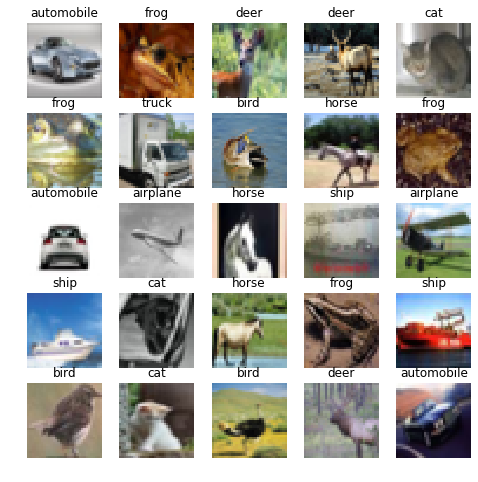

In [4]:
# This part will walk you through how to visualize the CIFAR-10 train dataset.
# We first find names of 10 categories.
f = open('data/cifar-10-batches-py/batches.meta', 'rb')
namedict = pickle.load(f, encoding='latin1')
f.close()
category = namedict['label_names']
# We then reshape vectorized data into the image format
X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1)

print(category)
print(X.shape)

#Visualizing CIFAR 10 data. We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        axes1[j][k].set_title(category[y_train[i]])

In [5]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the train set: indices 1~49,000
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
Development data shape: (100, 3072)
Development data shape (100,)


In [6]:
# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (100, 3073)


## Part 1: Linear SVM Classifier

In [7]:
from ecbm4040.classifiers.linear_svm import svm_loss_naive
from ecbm4040.classifiers.linear_svm import svm_loss_vectorized

# generate a random SVM weight matrix seeded with small numbers
np.random.seed(2345)
W = np.random.randn(3073, 10) * 0.0001 

## naive numpy implementation of SVM
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

## vectorized numpy implementation of SVM
tic = time.time()
loss_vec, grad_vec = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

## check the correctness
print('*'*100)
print('Relative loss error is {}'.format(abs(loss_vec-loss_naive)))
grad_err = np.linalg.norm(grad_naive - grad_vec, ord='fro')
print('Relative gradient error is {}'.format(grad_err))
print('Is vectorized loss correct? {}'.format(np.allclose(loss_naive, loss_vec)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_naive, grad_vec)))

naive numpy loss: 8.683932761909599, takes 0.0468440055847168 seconds.
vectorized numpy loss: 8.683932761909611, takes 0.0 seconds.
****************************************************************************************************
Relative loss error is 1.2434497875801753e-14
Relative gradient error is 5.957829797400877e-12
Is vectorized loss correct? True
Is vectorized gradient correct? True


## Part 2: Softmax classifier



In [8]:
from ecbm4040.classifiers.softmax import softmax_loss_naive
from ecbm4040.classifiers.softmax import softmax_loss_vectorized

## generate a random SVM weight matrix of small numbers
np.random.seed(2345)
W = np.random.randn(3073, 10) * 0.0001 

## ground truth of loss and gradient
W_tf = tf.placeholder(tf.float32, shape=(3073,10))
X = tf.placeholder(tf.float32, shape=(None, 3073))
y = tf.placeholder(tf.int32, shape=(None,))
reg = tf.constant(0.000005)
init_op = tf.global_variables_initializer()

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= tf.matmul(X, W_tf), labels=tf.one_hot(y,10))
loss0 = tf.reduce_mean(cross_entropy) + reg*tf.reduce_sum(W_tf*W_tf)
grad0 = tf.gradients(loss0, W_tf)
out0 = (loss0, grad0)
with tf.Session() as sess:
    sess.run(init_op)
    tic = time.time()
    loss_gt, grad_gt = sess.run(out0, feed_dict={W_tf: W, X: X_dev, y: y_dev})
    toc = time.time()

## naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

## vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

## Verify your result here - use 'rel_err' for error evaluation.
def rel_err(a,b):
    return np.mean(abs(a-b))

print('*'*100)
print('Relative loss error of naive softmax is {}'.format(rel_err(loss_gt,loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(rel_err(loss_gt,loss_vec)))
print('Gradient error of naive softmax is {}'.format(rel_err(grad_gt,grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(rel_err(grad_gt,grad_vec)))

naive numpy loss: 2.324022281366934, takes 0.046875 seconds.
vectorized numpy loss: 2.324022281366935, takes 0.0 seconds.
****************************************************************************************************
Relative loss error of naive softmax is 1.1723886306214126e-08
Relative loss error of vectorized softmax is 1.1723885418035707e-08
Gradient error of naive softmax is 2.660356188818693e-07
Gradient error of vectorized softmax is 2.6602844323329614e-07


## Part 3: Train your classifiers

### Train Linear SVM + SGD

In [9]:
from ecbm4040.classifiers.basic_classifiers import LinearSVM

## Linear SVM + SGD
classifier = LinearSVM()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both the
# training set and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 21.156737
iteration 100 / 1500: loss 10.371339
iteration 200 / 1500: loss 8.441832
iteration 300 / 1500: loss 10.634209
iteration 400 / 1500: loss 8.105033
iteration 500 / 1500: loss 9.137613
iteration 600 / 1500: loss 8.293254
iteration 700 / 1500: loss 7.885534
iteration 800 / 1500: loss 7.398189
iteration 900 / 1500: loss 6.220715
iteration 1000 / 1500: loss 6.805503
iteration 1100 / 1500: loss 7.047643
iteration 1200 / 1500: loss 7.208600
iteration 1300 / 1500: loss 6.223259
iteration 1400 / 1500: loss 6.926786
training accuracy: 0.299898
validation accuracy: 0.302000


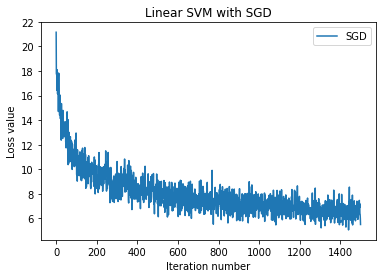

In [13]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.title('Linear SVM with SGD')
plt.legend()
plt.savefig('images/LinSVM.png')
plt.show()

### Train Softmax + SGD

In [14]:
from ecbm4040.classifiers.basic_classifiers import Softmax

## Softmax + SGD
classifier = Softmax()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 5.632195
iteration 100 / 1500: loss 4.088393
iteration 200 / 1500: loss 3.648163
iteration 300 / 1500: loss 3.457770
iteration 400 / 1500: loss 3.144134
iteration 500 / 1500: loss 3.071563
iteration 600 / 1500: loss 2.906680
iteration 700 / 1500: loss 3.218705
iteration 800 / 1500: loss 2.467908
iteration 900 / 1500: loss 2.950089
iteration 1000 / 1500: loss 2.820100
iteration 1100 / 1500: loss 2.725592
iteration 1200 / 1500: loss 2.625777
iteration 1300 / 1500: loss 2.559431
iteration 1400 / 1500: loss 2.592933
training accuracy: 0.243571
validation accuracy: 0.235000


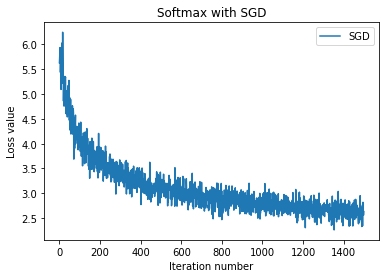

In [15]:
## SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.title('Softmax with SGD')
plt.legend()
plt.savefig('images/Softmax.png')
plt.show()